# BentoML Example: Keras Fashion MNIST

[BentoML](http://bentoml.ai) is an open source platform for machine learning model serving and deployment. 

This notebook demonstrates how to use BentoML to turn a Keras model into a docker image containing a REST API server serving this model, how to use your ML service built with BentoML as a CLI tool, and how to distribute it a pypi package.

![Impression](https://www.google-analytics.com/collect?v=1&tid=UA-112879361-3&cid=555&t=event&ec=keras&ea=keras-fashion-mnist&dt=keras-fashion-mnist)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#!pip install bentoml
!pip install tensorflow==1.14.0 numpy matplotlib keras

You should consider upgrading via the '/usr/local/anaconda3/envs/dev-py3/bin/python -m pip install --upgrade pip' command.


In [3]:
from __future__ import absolute_import, division, print_function

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
print("Tensorflow Version: %s" % tf.__version__)

import keras
print("Keras Version: %s" % keras.__version__)

import bentoml
print("BentoML Version: %s" % bentoml.__version__)

/usr/local/anaconda3/envs/dev-py3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/anaconda3/envs/dev-py3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/anaconda3/envs/dev-py3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/anaconda3/envs/dev-py3/lib/python3.7/s

Tensorflow Version: 1.14.0
Keras Version: 2.2.4
BentoML Version: 0.8.3+22.g2f60f1f5


## Load Fashion MNIST dataset

In [4]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

Each image is mapped to a single label. Since the class names are not included with the dataset, store them here to use later when plotting the images:

In [5]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Preprocess the data

The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255:

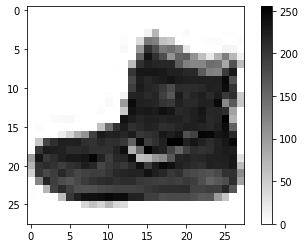

In [6]:
plt.figure()
plt.imshow(train_images[0], cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

We should scale these values to a range of 0 to 1 before feeding to the neural network model. For this, we divide the values by 255. It's important that the *training set* and the *testing set* are preprocessed in the same way:

In [7]:
train_images = train_images / 255.0
test_images = test_images / 255.0

Display the first 25 images from the training set and display the class name below each image. Verify that the data is in the correct format and we're ready to build and train the network.

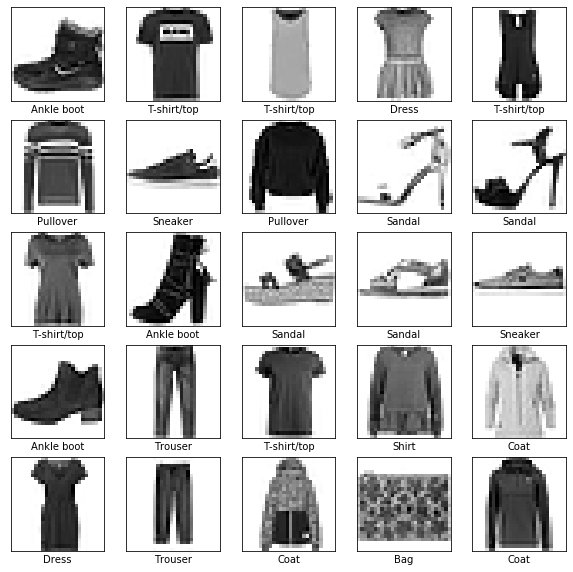

In [8]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [9]:
# Reshaping the images so that our model can accept it
train_images  = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

## Build the model

In [10]:
model = keras.Sequential()
# Must define the input shape in the first layer of the neural network
model.add(keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1))) 
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(10, activation='softmax'))
# Take a look at the model summary
model.summary()

W0719 20:02:39.538610 4608478656 deprecation_wrapper.py:119] From /usr/local/anaconda3/envs/dev-py3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0719 20:02:39.554958 4608478656 deprecation_wrapper.py:119] From /usr/local/anaconda3/envs/dev-py3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0719 20:02:39.557592 4608478656 deprecation_wrapper.py:119] From /usr/local/anaconda3/envs/dev-py3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0719 20:02:39.577418 4608478656 deprecation_wrapper.py:119] From /usr/local/anaconda3/envs/dev-py3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)              0         
__________

## Compile the model

In [11]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

W0719 20:02:41.093658 4608478656 deprecation_wrapper.py:119] From /usr/local/anaconda3/envs/dev-py3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0719 20:02:41.112263 4608478656 deprecation_wrapper.py:119] From /usr/local/anaconda3/envs/dev-py3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3341: The name tf.log is deprecated. Please use tf.math.log instead.



## Train the model

In [12]:
model.fit(train_images, train_labels, batch_size=64, epochs=1)

W0719 20:02:43.191725 4608478656 deprecation.py:323] From /usr/local/anaconda3/envs/dev-py3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/1
60000/60000 [==============================] - 52s 871us/step - loss: 0.5991 - acc: 0.7793


## Evaluate model accuracy

In [13]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

10000/10000 [==============================] - 3s 252us/step
Test accuracy: 0.8554


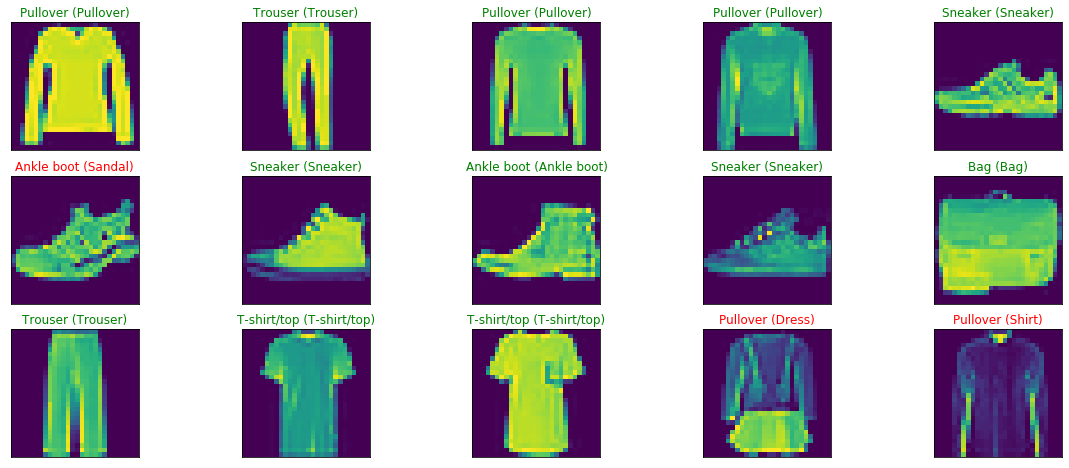

In [14]:
y_hat = model.predict_classes(test_images)

# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(test_images.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(test_images[index]))
    predict_index = y_hat[index]
    true_index = test_labels[index]
    # Set the title for each image
    ax.set_title("{} ({})".format(class_names[predict_index], 
                                  class_names[true_index]),
                                  color=("green" if predict_index == true_index else "red"))

## Predict on a single image

Let's first see the test image and and its label:

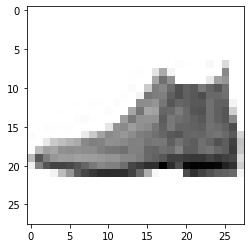

Class: Ankle boot


In [15]:
plt.imshow(test_images[0].squeeze(-1), cmap=plt.cm.binary)
plt.show()
print('Class:', class_names[test_labels[0]])

In [16]:
pred_idx = model.predict_classes(np.expand_dims(test_images[0], 0))[0]
print('Prediction:', class_names[pred_idx])

Prediction: Ankle boot


## Define BentoService for model serving

In [17]:
%%writefile keras_fashion_mnist.py

import numpy as np
from PIL import Image
from bentoml import api, artifacts, env, BentoService
from bentoml.artifact import KerasModelArtifact
from bentoml.adapters import ImageInput

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

@env(pip_dependencies=['keras', 'tensorflow==1.14.0', 'Pillow', 'numpy'])
@artifacts([KerasModelArtifact('classifier')])
class KerasFashionMnistService(BentoService):
        
    @api(input=ImageInput(pilmode='L'))
    def predict(self, imgs):
        inputs = []
        for img in imgs:
            img = Image.fromarray(img).resize((28, 28))
            img /= 255.0
            img = np.array(img.getdata()).reshape((28,28,1))
            inputs.append(img)
        inputs = np.stack(inputs)
        class_idxs = self.artifacts.classifier.predict_classes(inputs)
        return [class_names[class_idx] for class_idx in class_idxs]

Overwriting keras_fashion_mnist.py


## Save BentoService to file archive

In [18]:
# 1) import the custom BentoService defined above
from keras_fashion_mnist import KerasFashionMnistService

# 2) `pack` it with required artifacts
mnist_svc = KerasFashionMnistService()
mnist_svc.pack('classifier', model)

# 3) save your BentoSerivce to file archive
saved_path = mnist_svc.save()

[2020-07-19 20:13:10,790] WARNING - Using BentoML installed in `editable` model, the local BentoML repository including all code changes will be packaged together with saved bundle created, under the './bundled_pip_dependencies' directory of the saved bundle.
[2020-07-19 20:13:11,130] WARNING - Pillow package does not exist in the current python session


W0719 20:13:11.133131 4608478656 deprecation_wrapper.py:119] From /Users/bozhaoyu/src/bento/bentoml/artifact/keras_model_artifact.py:133: The name tf.keras.backend.get_session is deprecated. Please use tf.compat.v1.keras.backend.get_session instead.



[2020-07-19 20:13:36,741] INFO - Detect BentoML installed in development model, copying local BentoML module file to target saved bundle path
running sdist
running egg_info
writing BentoML.egg-info/PKG-INFO
writing dependency_links to BentoML.egg-info/dependency_links.txt
writing entry points to BentoML.egg-info/entry_points.txt
writing requirements to BentoML.egg-info/requires.txt
writing top-level names to BentoML.egg-info/top_level.txt
reading manifest file 'BentoML.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'


no previously-included directories found matching 'e2e_tests'
no previously-included directories found matching 'tests'
no previously-included directories found matching 'benchmark'


writing manifest file 'BentoML.egg-info/SOURCES.txt'
running check
creating BentoML-0.8.3+22.g2f60f1f5
creating BentoML-0.8.3+22.g2f60f1f5/BentoML.egg-info
creating BentoML-0.8.3+22.g2f60f1f5/bentoml
creating BentoML-0.8.3+22.g2f60f1f5/bentoml/adapters
creating BentoML-0.8.3+22.g2f60f1f5/bentoml/artifact
creating BentoML-0.8.3+22.g2f60f1f5/bentoml/cli
creating BentoML-0.8.3+22.g2f60f1f5/bentoml/clipper
creating BentoML-0.8.3+22.g2f60f1f5/bentoml/configuration
creating BentoML-0.8.3+22.g2f60f1f5/bentoml/configuration/__pycache__
creating BentoML-0.8.3+22.g2f60f1f5/bentoml/handlers
creating BentoML-0.8.3+22.g2f60f1f5/bentoml/marshal
creating BentoML-0.8.3+22.g2f60f1f5/bentoml/saved_bundle
creating BentoML-0.8.3+22.g2f60f1f5/bentoml/server
creating BentoML-0.8.3+22.g2f60f1f5/bentoml/utils
creating BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai
creating BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/client
creating BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/deployment
creating BentoML-0.8.3+22.g2f60f1f5

creating BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/mime-db
creating BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/mime-types
creating BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/mime/src
creating BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/ms
creating BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/negotiator
creating BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/negotiator/lib
creating BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/on-finished
creating BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/parseurl
creating BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/path-to-regexp
creating BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/protobufjs
creating BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/protobufjs/bin
creating BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/protobufjs/cli
cr

copying bentoml/artifact/keras_model_artifact.py -> BentoML-0.8.3+22.g2f60f1f5/bentoml/artifact
copying bentoml/artifact/lightgbm_model_artifact.py -> BentoML-0.8.3+22.g2f60f1f5/bentoml/artifact
copying bentoml/artifact/onnx_model_artifact.py -> BentoML-0.8.3+22.g2f60f1f5/bentoml/artifact
copying bentoml/artifact/pickle_artifact.py -> BentoML-0.8.3+22.g2f60f1f5/bentoml/artifact
copying bentoml/artifact/pytorch_model_artifact.py -> BentoML-0.8.3+22.g2f60f1f5/bentoml/artifact
copying bentoml/artifact/sklearn_model_artifact.py -> BentoML-0.8.3+22.g2f60f1f5/bentoml/artifact
copying bentoml/artifact/spacy_model_artifact.py -> BentoML-0.8.3+22.g2f60f1f5/bentoml/artifact
copying bentoml/artifact/text_file_artifact.py -> BentoML-0.8.3+22.g2f60f1f5/bentoml/artifact
copying bentoml/artifact/tf_savedmodel_artifact.py -> BentoML-0.8.3+22.g2f60f1f5/bentoml/artifact
copying bentoml/artifact/xgboost_model_artifact.py -> BentoML-0.8.3+22.g2f60f1f5/bentoml/artifact
copying bentoml/cli/__init__.py -> Be

copying bentoml/yatai/deployment/azure_functions/host.json -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/deployment/azure_functions
copying bentoml/yatai/deployment/azure_functions/local.settings.json -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/deployment/azure_functions
copying bentoml/yatai/deployment/azure_functions/operator.py -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/deployment/azure_functions
copying bentoml/yatai/deployment/azure_functions/templates.py -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/deployment/azure_functions
copying bentoml/yatai/deployment/sagemaker/__init__.py -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/deployment/sagemaker
copying bentoml/yatai/deployment/sagemaker/model_server.py -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/deployment/sagemaker
copying bentoml/yatai/deployment/sagemaker/nginx.conf -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/deployment/sagemaker
copying bentoml/yatai/deployment/sagemaker/operator.py -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/dep

copying bentoml/yatai/web/dist/node_modules/@protobufjs/eventemitter/package.json -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/@protobufjs/eventemitter
copying bentoml/yatai/web/dist/node_modules/@protobufjs/eventemitter/tests/index.js -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/@protobufjs/eventemitter/tests
copying bentoml/yatai/web/dist/node_modules/@protobufjs/fetch/LICENSE -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/@protobufjs/fetch
copying bentoml/yatai/web/dist/node_modules/@protobufjs/fetch/README.md -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/@protobufjs/fetch
copying bentoml/yatai/web/dist/node_modules/@protobufjs/fetch/index.d.ts -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/@protobufjs/fetch
copying bentoml/yatai/web/dist/node_modules/@protobufjs/fetch/index.js -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/@protobufjs/fetch
copying bentoml/yatai/we

copying bentoml/yatai/web/dist/node_modules/@types/node/LICENSE -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/@types/node
copying bentoml/yatai/web/dist/node_modules/@types/node/README.md -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/@types/node
copying bentoml/yatai/web/dist/node_modules/@types/node/assert.d.ts -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/@types/node
copying bentoml/yatai/web/dist/node_modules/@types/node/async_hooks.d.ts -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/@types/node
copying bentoml/yatai/web/dist/node_modules/@types/node/base.d.ts -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/@types/node
copying bentoml/yatai/web/dist/node_modules/@types/node/buffer.d.ts -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/@types/node
copying bentoml/yatai/web/dist/node_modules/@types/node/child_process.d.ts -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist

copying bentoml/yatai/web/dist/node_modules/accepts/package.json -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/accepts
copying bentoml/yatai/web/dist/node_modules/array-flatten/LICENSE -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/array-flatten
copying bentoml/yatai/web/dist/node_modules/array-flatten/README.md -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/array-flatten
copying bentoml/yatai/web/dist/node_modules/array-flatten/array-flatten.js -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/array-flatten
copying bentoml/yatai/web/dist/node_modules/array-flatten/package.json -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/array-flatten
copying bentoml/yatai/web/dist/node_modules/body-parser/HISTORY.md -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/body-parser
copying bentoml/yatai/web/dist/node_modules/body-parser/LICENSE -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist

copying bentoml/yatai/web/dist/node_modules/depd/History.md -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/depd
copying bentoml/yatai/web/dist/node_modules/depd/LICENSE -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/depd
copying bentoml/yatai/web/dist/node_modules/depd/Readme.md -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/depd
copying bentoml/yatai/web/dist/node_modules/depd/index.js -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/depd
copying bentoml/yatai/web/dist/node_modules/depd/package.json -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/depd
copying bentoml/yatai/web/dist/node_modules/depd/lib/browser/index.js -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/depd/lib/browser
copying bentoml/yatai/web/dist/node_modules/depd/lib/compat/callsite-tostring.js -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/depd/lib/compat
copying bentoml/yatai/web/dist/no

copying bentoml/yatai/web/dist/node_modules/fresh/LICENSE -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/fresh
copying bentoml/yatai/web/dist/node_modules/fresh/README.md -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/fresh
copying bentoml/yatai/web/dist/node_modules/fresh/index.js -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/fresh
copying bentoml/yatai/web/dist/node_modules/fresh/package.json -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/fresh
copying bentoml/yatai/web/dist/node_modules/http-errors/HISTORY.md -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/http-errors
copying bentoml/yatai/web/dist/node_modules/http-errors/LICENSE -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/http-errors
copying bentoml/yatai/web/dist/node_modules/http-errors/README.md -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/http-errors
copying bentoml/yatai/web/dist/node_modul

copying bentoml/yatai/web/dist/node_modules/media-typer/README.md -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/media-typer
copying bentoml/yatai/web/dist/node_modules/media-typer/index.js -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/media-typer
copying bentoml/yatai/web/dist/node_modules/media-typer/package.json -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/media-typer
copying bentoml/yatai/web/dist/node_modules/merge-descriptors/HISTORY.md -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/merge-descriptors
copying bentoml/yatai/web/dist/node_modules/merge-descriptors/LICENSE -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/merge-descriptors
copying bentoml/yatai/web/dist/node_modules/merge-descriptors/README.md -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/merge-descriptors
copying bentoml/yatai/web/dist/node_modules/merge-descriptors/index.js -> BentoML-0.8.3+22.g2f60f1f

copying bentoml/yatai/web/dist/node_modules/path-to-regexp/Readme.md -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/path-to-regexp
copying bentoml/yatai/web/dist/node_modules/path-to-regexp/index.js -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/path-to-regexp
copying bentoml/yatai/web/dist/node_modules/path-to-regexp/package.json -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/path-to-regexp
copying bentoml/yatai/web/dist/node_modules/protobufjs/CHANGELOG.md -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/protobufjs
copying bentoml/yatai/web/dist/node_modules/protobufjs/LICENSE -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/protobufjs
copying bentoml/yatai/web/dist/node_modules/protobufjs/README.md -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/protobufjs
copying bentoml/yatai/web/dist/node_modules/protobufjs/index.d.ts -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/no

copying bentoml/yatai/web/dist/node_modules/protobufjs/dist/light/README.md -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/protobufjs/dist/light
copying bentoml/yatai/web/dist/node_modules/protobufjs/dist/light/protobuf.js -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/protobufjs/dist/light
copying bentoml/yatai/web/dist/node_modules/protobufjs/dist/light/protobuf.js.map -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/protobufjs/dist/light
copying bentoml/yatai/web/dist/node_modules/protobufjs/dist/light/protobuf.min.js -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/protobufjs/dist/light
copying bentoml/yatai/web/dist/node_modules/protobufjs/dist/light/protobuf.min.js.map -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/protobufjs/dist/light
copying bentoml/yatai/web/dist/node_modules/protobufjs/dist/minimal/README.md -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/protobufjs/d

copying bentoml/yatai/web/dist/node_modules/protobufjs/src/roots.js -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/protobufjs/src
copying bentoml/yatai/web/dist/node_modules/protobufjs/src/rpc.js -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/protobufjs/src
copying bentoml/yatai/web/dist/node_modules/protobufjs/src/service.js -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/protobufjs/src
copying bentoml/yatai/web/dist/node_modules/protobufjs/src/tokenize.js -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/protobufjs/src
copying bentoml/yatai/web/dist/node_modules/protobufjs/src/type.js -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/protobufjs/src
copying bentoml/yatai/web/dist/node_modules/protobufjs/src/types.js -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/protobufjs/src
copying bentoml/yatai/web/dist/node_modules/protobufjs/src/typescript.jsdoc -> BentoML-0.8.3+22.g2f60f1f

copying bentoml/yatai/web/dist/node_modules/safer-buffer/package.json -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/safer-buffer
copying bentoml/yatai/web/dist/node_modules/safer-buffer/safer.js -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/safer-buffer
copying bentoml/yatai/web/dist/node_modules/safer-buffer/tests.js -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/safer-buffer
copying bentoml/yatai/web/dist/node_modules/send/HISTORY.md -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/send
copying bentoml/yatai/web/dist/node_modules/send/LICENSE -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/send
copying bentoml/yatai/web/dist/node_modules/send/README.md -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/send
copying bentoml/yatai/web/dist/node_modules/send/index.js -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/send
copying bentoml/yatai/web/dist/node_modules

copying bentoml/yatai/web/dist/node_modules/utils-merge/LICENSE -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/utils-merge
copying bentoml/yatai/web/dist/node_modules/utils-merge/README.md -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/utils-merge
copying bentoml/yatai/web/dist/node_modules/utils-merge/index.js -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/utils-merge
copying bentoml/yatai/web/dist/node_modules/utils-merge/package.json -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/utils-merge
copying bentoml/yatai/web/dist/node_modules/vary/HISTORY.md -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/vary
copying bentoml/yatai/web/dist/node_modules/vary/LICENSE -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/vary
copying bentoml/yatai/web/dist/node_modules/vary/README.md -> BentoML-0.8.3+22.g2f60f1f5/bentoml/yatai/web/dist/node_modules/vary
copying bentoml/yatai/web/dist/node

## Load BentoService from archive


In [26]:
svc = bentoml.load(saved_path)
svc.predict(test_images[0].squeeze(-1))

[2020-02-06 11:45:22,808] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be bundled together with the BentoService bundle. When used with docker, the base docker image will be default to same version as last PyPI release at version: 0.6.1. You can also force bentoml to use a specific version for deploying your BentoService bundle, by setting the config 'core/bentoml_deploy_version' to a pinned version or your custom BentoML on github, e.g.:'bentoml_deploy_version = git+https://github.com/{username}/bentoml.git@{branch}'
[2020-02-06 11:45:22,817] WARNING - Saved BentoService bundle version mismatch: loading BentoServie bundle create with BentoML version 0.6.1,  but loading from BentoML version 0.6.1+4.gd82c2f1
[2020-02-06 11:45:22,819] WARNING - Module `keras_fashion_mnist` already loaded, using existing imported module.
[2020-02-06 11:45:24,788] WARNING - BentoML local changes detected - Local BentoML repository including all code ch

'Ankle boot'

# "pip install" a BentoService archive

BentoML user can directly pip install saved BentoML archive with `pip install $SAVED_PATH`,  and use it as a regular python package.

In [19]:
!pip install {saved_path}

Processing /Users/chaoyuyang/bentoml/repository/KerasFashionMnistService/20191014170448_88D4B9
  Stored in directory: /private/var/folders/ns/vc9qhmqx5dx_9fws7d869lqh0000gn/T/pip-ephem-wheel-cache-3zons_vs/wheels/45/c6/cd/deadc3b6f904fad3a76d71e15d8a469e37def04f583182ceee
Successfully built KerasFashionMnistService
  Found existing installation: KerasFashionMnistService 20191014170128-BB7310
    Uninstalling KerasFashionMnistService-20191014170128-BB7310:
      Successfully uninstalled KerasFashionMnistService-20191014170128-BB7310


In [20]:
# Your bentoML model class name will become packaged name
import KerasFashionMnistService

ms = KerasFashionMnistService.load()
ms.predict(test_images[0].squeeze(-1))

'Ankle boot'

# Use BentoService with BentoML CLI

List BentoService's all version with `bentoml get`

In [27]:
!bentoml get KerasFashionMnistService

BENTO_SERVICE                                   CREATED_AT        APIS                   ARTIFACTS
KerasFashionMnistService:20200206114430_94F93D  2020-02-06 19:44  predict::ImageHandler  classifier::KerasModelArtifact
KerasFashionMnistService:20200206113040_3B9AE5  2020-02-06 19:31  predict::ImageHandler  classifier::KerasModelArtifact


Use `bentoml get <ServiceName>:<ServiceVersion>` to get metadata and other details

In [28]:
!bentoml get KerasFashionMnistService:20200206114430_94F93D

{
  "name": "KerasFashionMnistService",
  "version": "20200206114430_94F93D",
  "uri": {
    "type": "LOCAL",
    "uri": "/Users/bozhaoyu/bentoml/repository/KerasFashionMnistService/20200206114430_94F93D"
  },
  "bentoServiceMetadata": {
    "name": "KerasFashionMnistService",
    "version": "20200206114430_94F93D",
    "createdAt": "2020-02-06T19:44:56.394213Z",
    "env": {
      "condaEnv": "name: bentoml-KerasFashionMnistService\nchannels:\n- defaults\ndependencies:\n- python=3.7.3\n- pip\n",
      "pipDependencies": "bentoml==0.6.1\nkeras\ntensorflow==1.14.0\nPillow\nnumpy\nimageio",
      "pythonVersion": "3.7.3"
    },
    "artifacts": [
      {
        "name": "classifier",
        "artifactType": "KerasModelArtifact"
      }
    ],
    "apis": [
      {
        "name": "predict",
        "handlerType": "ImageHandler",
        "docs": "BentoService API"
      }
    ]
  }
}


**With `bentoml run` we can quickly test and validate the prediction result with sample data**

In [29]:
!bentoml run KerasFashionMnistService:20200206114430_94F93D predict --input=sample_image.png

[2020-02-06 11:48:04,522] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be bundled together with the BentoService bundle. When used with docker, the base docker image will be default to same version as last PyPI release at version: 0.6.1. You can also force bentoml to use a specific version for deploying your BentoService bundle, by setting the config 'core/bentoml_deploy_version' to a pinned version or your custom BentoML on github, e.g.:'bentoml_deploy_version = git+https://github.com/{username}/bentoml.git@{branch}'
[2020-02-06 11:48:04,534] WARNING - Saved BentoService bundle version mismatch: loading BentoServie bundle create with BentoML version 0.6.1,  but loading from BentoML version 0.6.1+4.gd82c2f1
[2020-02-06 11:48:08,233] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be bundled together with the BentoService bundle. When used with docker, the base docker image will be

**Start a local realtime prediction service with `bentoml serve`**

In [31]:
!bentoml serve KerasFashionMnistService:20200206114430_94F93D

[2020-02-06 11:49:37,963] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be bundled together with the BentoService bundle. When used with docker, the base docker image will be default to same version as last PyPI release at version: 0.6.1. You can also force bentoml to use a specific version for deploying your BentoService bundle, by setting the config 'core/bentoml_deploy_version' to a pinned version or your custom BentoML on github, e.g.:'bentoml_deploy_version = git+https://github.com/{username}/bentoml.git@{branch}'
[2020-02-06 11:49:37,976] WARNING - Saved BentoService bundle version mismatch: loading BentoServie bundle create with BentoML version 0.6.1,  but loading from BentoML version 0.6.1+4.gd82c2f1
[2020-02-06 11:49:41,662] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be bundled together with the BentoService bundle. When used with docker, the base docker image will be

Test sending request to API Server from terminal:

```bash
curl -X POST "http://127.0.0.1:5000/predict" -F image=@sample_image.png
```

or:

```bash
curl -X POST "http://127.0.0.1:5000/predict" -H "Content-Type: image/png" --data-binary @sample_image.png
```

# Use BentoService as PyPI package

In [33]:
!cd {saved_path} && pip install .

Processing /Users/bozhaoyu/bentoml/repository/KerasFashionMnistService/20200206114430_94F93D
  Created wheel for KerasFashionMnistService: filename=KerasFashionMnistService-20200206114430_94F93D-py3-none-any.whl size=4674994 sha256=9223b063c8feebb38338bc4504ca5d05402a48007f6afa692a478b7fd1c52141
  Stored in directory: /private/var/folders/kn/xnc9k74x03567n1mx2tfqnpr0000gn/T/pip-ephem-wheel-cache-x6ygrc7k/wheels/9f/f5/dc/53ac3e76296c27213f9f8a916cf5b81124f90e49978eee694b
Successfully built KerasFashionMnistService


In [35]:
!KerasFashionMnistService run predict --input=sample_image.png

[2020-02-06 14:23:57,140] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be bundled together with the BentoService bundle. When used with docker, the base docker image will be default to same version as last PyPI release at version: 0.6.1. You can also force bentoml to use a specific version for deploying your BentoService bundle, by setting the config 'core/bentoml_deploy_version' to a pinned version or your custom BentoML on github, e.g.:'bentoml_deploy_version = git+https://github.com/{username}/bentoml.git@{branch}'
[2020-02-06 14:23:57,158] WARNING - Saved BentoService bundle version mismatch: loading BentoServie bundle create with BentoML version 0.6.1,  but loading from BentoML version 0.6.1+4.gd82c2f1
[2020-02-06 14:23:57,160] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be bundled together with the BentoService bundle. When used with docker, the base docker image will be

## Containerize REST API server with Docker

** _Make sure you have `docker` installed, note that it is not available when running in Google Colaboratory_

In [36]:
!cd {saved_path} && docker build -t keras-fashion-mnist .

Sending build context to Docker daemon  6.004MB
Step 1/12 : FROM continuumio/miniconda3:4.7.12
4.7.12: Pulling from continuumio/miniconda3
Digest: sha256:6c979670684d970f8ba934bf9b7bf42e77c30a22eb96af1f30a039b484719159
Status: Downloaded newer image for continuumio/miniconda3:4.7.12
 ---> 406f2b43ea59
Step 2/12 : ENTRYPOINT [ "/bin/bash", "-c" ]
 ---> Using cache
 ---> 28172be83c07
Step 3/12 : EXPOSE 5000
 ---> Using cache
 ---> 840844d191d4
Step 4/12 : RUN set -x      && apt-get update      && apt-get install --no-install-recommends --no-install-suggests -y libpq-dev build-essential      && rm -rf /var/lib/apt/lists/*
 ---> Using cache
 ---> 243c05e712f3
Step 5/12 : RUN conda install pip numpy scipy       && pip install gunicorn
 ---> Using cache
 ---> 8fab95ab34fc
Step 6/12 : COPY . /bento
 ---> a000f9f4d4da
Step 7/12 : WORKDIR /bento
 ---> Running in 7b55d887cbfe
Removing intermediate container 7b55d887cbfe
 ---> 626eaec4dbed
Step 8/12 : RUN if [ -f /bento/setup.sh ]; then /bin/bash

In [37]:
!docker run -p 5000:5000 keras-fashion-mnist

[2020-02-06 22:27:07,808] INFO - get_gunicorn_num_of_workers: 3, calculated by cpu count
[2020-02-06 22:27:08 +0000] [1] [INFO] Starting gunicorn 20.0.4
[2020-02-06 22:27:08 +0000] [1] [INFO] Listening at: http://0.0.0.0:5000 (1)
[2020-02-06 22:27:08 +0000] [1] [INFO] Using worker: sync
[2020-02-06 22:27:08 +0000] [9] [INFO] Booting worker with pid: 9
[2020-02-06 22:27:08 +0000] [10] [INFO] Booting worker with pid: 10
[2020-02-06 22:27:08 +0000] [11] [INFO] Booting worker with pid: 11
[2020-02-06 22:27:08,273] WARNING - Saved BentoService bundle version mismatch: loading BentoServie bundle create with BentoML version 0.6.1,  but loading from BentoML version 0.6.1+4.gd82c2f1
[2020-02-06 22:27:08,396] WARNING - Saved BentoService bundle version mismatch: loading BentoServie bundle create with BentoML version 0.6.1,  but loading from BentoML version 0.6.1+4.gd82c2f1
[2020-02-06 22:27:08,411] WARNING - Saved BentoService bundle version mismatch: loading BentoServie bundle create with Bento

# Deploy BentoService as REST API server to the cloud


BentoML support deployment to multiply cloud provider services, such as AWS Lambda, AWS Sagemaker, Google Cloudrun and etc. You can find the full list and guide on the documentation site at https://docs.bentoml.org/en/latest/deployment/index.html

For this demo, we are going to deploy to AWS Sagemaker

**Use `bentoml sagemaker deploy` to deploy BentoService**

In [45]:
!bentoml sagemaker deploy test-keras-mnist -b KerasFashionMnistService:20200206114430_94F93D --api-name predict --verbose

[2020-02-06 15:47:57,164] DEBUG - Using BentoML with local Yatai server
[2020-02-06 15:47:57,322] DEBUG - Upgrading tables to the latest revision
Deploying Sagemaker deployment /[2020-02-06 15:47:58,250] DEBUG - Created temporary directory: /private/var/folders/kn/xnc9k74x03567n1mx2tfqnpr0000gn/T/bentoml-temp-5a0fqpd0
/[2020-02-06 15:47:58,749] DEBUG - Getting docker login info from AWS
[2020-02-06 15:47:58,750] DEBUG - Building docker image: 192023623294.dkr.ecr.us-west-2.amazonaws.com/kerasfashionmnistservice-sagemaker:20200206114430_94F93D
|[2020-02-06 15:47:59,254] INFO - Step 1/11 : FROM continuumio/miniconda3:4.7.12
[2020-02-06 15:47:59,255] INFO - 

[2020-02-06 15:47:59,255] INFO -  ---> 406f2b43ea59

[2020-02-06 15:47:59,255] INFO - Step 2/11 : EXPOSE 8080
[2020-02-06 15:47:59,255] INFO - 

[2020-02-06 15:47:59,255] INFO -  ---> Using cache

[2020-02-06 15:47:59,255] INFO -  ---> 7c8096d6922f

[2020-02-06 15:47:59,256] INFO - Step 3/11 : RUN set -x      && apt-get update     

Use `bentoml sagemaker list` to list all of the Sagemaker deployments

In [46]:
!bentoml sagemaker list

NAME              NAMESPACE    LABELS    PLATFORM       STATUS    AGE
test-keras-mnist  bobo                   aws-sagemaker  running   21 minutes and 33.68 seconds


Validating Sagemaker deployment result with sample data

In [47]:
!aws sagemaker-runtime invoke-endpoint --endpoint-name bobo-test-keras-mnist \
--body fileb:///Users/bozhaoyu/src/bento_gallery/keras/fashion-mnist/sample_image.png \
--content-type image/png output.json && cat output.json

{
    "ContentType": "application/json",
    "InvokedProductionVariant": "bobo-test-keras-m-KerasFashionMnistSer-20200206114430-94F93D"
}
"Ankle boot"

Deleting deployment is as easy as deploying it. With `bentoml sagemaker delete` it will delete the deployment along with related resources

In [48]:
!bentoml sagemaker delete test-keras-mnist

Successfully deleted AWS Sagemaker deployment "test-keras-mnist"
